<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL/blob/master/Stock_NeurIPS2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

* **Pytorch Version** 



# Content

* [1. Task Description](#0)
* [2. Install Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. A List of Python Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download and Preprocess Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5. Build Market Environment in OpenAI Gym-style](#4)  
    * [5.1. Data Split](#4.1)  
    * [5.3. Environment for Training](#4.2)    
* [6. Train DRL Agents](#5)
* [7. Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
  

<a id='0'></a>
# Part 1. Task Discription

We train a DRL agent for stock trading. This task is modeled as a Markov Decision Process (MDP), and the objective function is maximizing (expected) cumulative return.

We specify the state-action-reward as follows:

* **State s**: The state space represents an agent's perception of the market environment. Just like a human trader analyzing various information, here our agent passively observes many features and learns by interacting with the market environment (usually by replaying historical data).

* **Action a**: The action space includes allowed actions that an agent can take at each state. For example, a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying. When an action operates multiple shares, a ∈{−k, ..., −1, 0, 1, ..., k}, e.g.. "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* **Reward function r(s, a, s′)**: Reward is an incentive for an agent to learn a better policy. For example, it can be the change of the portfolio value when taking a at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio values at state s′ and s, respectively


**Market environment**: 30 consituent stocks of Dow Jones Industrial Average (DJIA) index. Accessed at the starting date of the testing period.


The data for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Install Python Packages

<a id='1.1'></a>
## 2.1. Install packages


In [ ]:
## install finrl library
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git


<a id='1.2'></a>
## 2.2. A list of Python packages 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL")

import itertools

<a id='1.4'></a>
## 2.4. Create Folders

In [ ]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])



<a id='2'></a>
# Part 3. Download Data
Yahoo Finance provides stock data, financial news, financial reports, etc. Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** in FinRL-Meta to fetch data via Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).



-----
class YahooDownloader:
    Retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()


In [ ]:
# from config.py, TRAIN_START_DATE is a string
TRAIN_START_DATE
# from config.py, TRAIN_END_DATE is a string
TRAIN_END_DATE

'2014-01-01'

In [ ]:
TRAIN_START_DATE = '2009-01-01'
TRAIN_END_DATE = '2020-07-01'
TRADE_START_DATE = '2020-07-01'
TRADE_END_DATE = '2021-10-31'


'2020-07-31'

In [ ]:
df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
print(config_tickers.DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [ ]:
df.shape

(94331, 8)

In [ ]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2009-01-02,3.067143,3.251429,3.041429,2.771174,746015200,AAPL,4
1,2009-01-02,58.590000,59.080002,57.750000,44.867603,6547900,AMGN,4
2,2009-01-02,18.570000,19.520000,18.400000,15.535339,10955700,AXP,4
3,2009-01-02,42.799999,45.560001,42.779999,33.941097,7010200,BA,4
4,2009-01-02,44.910000,46.980000,44.709999,32.164722,7117200,CAT,4


# Part 4: Preprocess Data
We need to check for missing data and do feature engineering to convert the data point into a state.
* **Adding technical indicators**. In practical trading, various information needs to be taken into account, such as historical prices, current holding shares, technical indicators, etc. Here, we demonstrate two trend-following technical indicators: MACD and RSI.
* **Adding turbulence index**. Risk-aversion reflects whether an investor prefers to protect the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the turbulence index that measures extreme fluctuation of asset price.

In [ ]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3229, 8)
Successfully added vix
Successfully added turbulence index


In [ ]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [ ]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2009-01-02,AAPL,3.067143,3.251429,3.041429,2.771174,746015200.0,4.0,0.0,2.99505,2.664252,100.0,66.666667,100.0,2.771174,2.771174,39.189999,0.0
1,2009-01-02,AMGN,58.590000,59.080002,57.750000,44.867603,6547900.0,4.0,0.0,2.99505,2.664252,100.0,66.666667,100.0,44.867603,44.867603,39.189999,0.0
2,2009-01-02,AXP,18.570000,19.520000,18.400000,15.535339,10955700.0,4.0,0.0,2.99505,2.664252,100.0,66.666667,100.0,15.535339,15.535339,39.189999,0.0
3,2009-01-02,BA,42.799999,45.560001,42.779999,33.941097,7010200.0,4.0,0.0,2.99505,2.664252,100.0,66.666667,100.0,33.941097,33.941097,39.189999,0.0
4,2009-01-02,CAT,44.910000,46.980000,44.709999,32.164722,7117200.0,4.0,0.0,2.99505,2.664252,100.0,66.666667,100.0,32.164722,32.164722,39.189999,0.0
5,2009-01-02,CRM,8.025000,8.550000,7.912500,8.505000,4069200.0,4.0,0.0,2.99505,2.664252,100.0,66.666667,100.0,8.505000,8.505000,39.189999,0.0
6,2009-01-02,CSCO,16.410000,17.000000,16.250000,12.265081,40980600.0,4.0,0.0,2.99505,2.664252,100.0,66.666667,100.0,12.265081,12.265081,39.189999,0.0
7,2009-01-02,CVX,74.230003,77.300003,73.580002,44.807625,13695900.0,4.0,0.0,2.99505,2.664252,100.0,66.666667,100.0,44.807625,44.807625,39.189999,0.0
8,2009-01-02,DIS,22.760000,24.030001,22.500000,20.597496,9796600.0,4.0,0.0,2.99505,2.664252,100.0,66.666667,100.0,20.597496,20.597496,39.189999,0.0
9,2009-01-02,GS,84.019997,87.620003,82.190002,70.735085,14088500.0,4.0,0.0,2.99505,2.664252,100.0,66.666667,100.0,70.735085,70.735085,39.189999,0.0


<a id='4'></a>
# Part 5. Build A Market Environment in OpenAI Gym-style
The training process involves observing stock price change, taking an action and reward's calculation. By interacting with the market environment, the agent will eventually derive a trading strategy that may maximize (expected) rewards.

Our market environment, based on OpenAI Gym, simulates stock markets with historical market data.

## Data Split
We split the data into training set and testing set as follows:

Training data period: 2009-01-01 to 2020-07-01

Trading data period: 2020-07-01 to 2021-10-31


In [ ]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

83897
9744


In [ ]:
train.tail()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
2892,2020-06-30,UNH,288.570007,296.450012,287.660004,286.754120,2932900.0,1.0,-0.019414,302.845863,270.287352,52.413031,-25.866470,1.846804,286.997200,280.002896,30.43,12.918775
2892,2020-06-30,V,191.490005,193.750000,190.160004,190.737228,9040100.0,1.0,1.048786,198.750525,185.041392,53.021032,-51.550900,2.013358,191.485034,181.677681,30.43,12.918775
2892,2020-06-30,VZ,54.919998,55.290001,54.360001,50.376740,17414800.0,1.0,-0.437111,53.918425,48.729322,48.097035,-51.018335,8.508886,51.012122,51.464678,30.43,12.918775
2892,2020-06-30,WBA,42.119999,42.580002,41.759998,39.035740,4782100.0,1.0,-0.083986,42.609306,36.487096,48.830195,-14.508002,1.500723,39.135190,38.935129,30.43,12.918775
2892,2020-06-30,WMT,119.220001,120.129997,118.540001,116.121780,6836400.0,1.0,-0.886569,119.473763,113.510452,48.159685,-69.938644,3.847271,117.787628,119.723274,30.43,12.918775


In [ ]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2020-07-01,AAPL,91.279999,91.839996,90.977501,89.904617,110737200.0,2.0,3.014606,92.699321,80.179950,62.807170,107.491949,29.730532,83.933767,77.717542,28.620001,53.068073
0,2020-07-01,AMGN,235.520004,256.230011,232.580002,240.153961,6575800.0,2.0,3.636392,232.397419,200.212942,61.279641,271.386208,46.806139,214.858661,215.931666,28.620001,53.068073
0,2020-07-01,AXP,95.250000,96.959999,93.639999,92.086380,3301000.0,2.0,-0.389162,110.423944,87.759333,48.504818,-66.328704,3.142448,97.244637,90.695525,28.620001,53.068073
0,2020-07-01,BA,185.880005,190.610001,180.039993,180.320007,49036700.0,2.0,5.443193,220.721139,160.932863,50.925771,24.220608,15.932920,176.472335,155.614168,28.620001,53.068073
0,2020-07-01,CAT,129.380005,129.399994,125.879997,120.651634,2807800.0,2.0,1.272630,130.624272,113.353134,52.865419,35.597297,14.457404,119.412837,113.646674,28.620001,53.068073


In [ ]:
INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [ ]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 29, State Space: 291


In [ ]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

## Environment for Training



In [ ]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Train DRL Agents
* The DRL algorithms are from **Stable Baselines 3**. Users are also encouraged to try **ElegantRL** and **Ray RLlib**.
* FinRL includes fine-tuned standard DRL algorithms, such as DQN, DDPG, Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [ ]:
agent = DRLAgent(env = env_train)

### Agent Training: 5 algorithms (A2C, DDPG, PPO, TD3, SAC)


### Agent 1: A2C


In [ ]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device


In [ ]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000)

---------------------------------------
| time/                 |             |
|    fps                | 85          |
|    iterations         | 100         |
|    time_elapsed       | 5           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -41.1       |
|    explained_variance | 0.225       |
|    learning_rate      | 0.0007      |
|    n_updates          | 99          |
|    policy_loss        | -3.3        |
|    reward             | -0.38245595 |
|    std                | 0.997       |
|    value_loss         | 0.81        |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 86         |
|    iterations         | 200        |
|    time_elapsed       | 11         |
|    total_timesteps    | 1000       |
| train/                |            |
|    entropy_loss       | -41.1      |
|    explained_variance | -0.00998   |
|    lear

### Agent 2: DDPG

In [ ]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device


In [ ]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000)

day: 2892, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 4817633.79
total_reward: 3817633.79
total_cost: 6109.81
total_trades: 54806
Sharpe: 0.927
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 29        |
|    time_elapsed    | 394       |
|    total_timesteps | 11572     |
| train/             |           |
|    actor_loss      | -41.3     |
|    critic_loss     | 101       |
|    learning_rate   | 0.001     |
|    n_updates       | 8679      |
|    reward          | 1.4751048 |
----------------------------------


### Agent 3: PPO

In [ ]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device


In [ ]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=50000)

-----------------------------------
| time/              |            |
|    fps             | 96         |
|    iterations      | 1          |
|    time_elapsed    | 21         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | 0.30886105 |
-----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 2           |
|    time_elapsed         | 43          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.015826263 |
|    clip_fraction        | 0.205       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | -0.0394     |
|    learning_rate        | 0.00025     |
|    loss                 | 6.77        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0202     |
|   

### Agent 4: TD3

In [ ]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device


In [ ]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=30000)

day: 2892, episode: 60
begin_total_asset: 1000000.00
end_total_asset: 3941856.98
total_reward: 2941856.98
total_cost: 999.00
total_trades: 49164
Sharpe: 0.718
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 31        |
|    time_elapsed    | 370       |
|    total_timesteps | 11572     |
| train/             |           |
|    actor_loss      | 55.7      |
|    critic_loss     | 3.7e+03   |
|    learning_rate   | 0.001     |
|    n_updates       | 8679      |
|    reward          | 1.2822058 |
----------------------------------
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 27        |
|    time_elapsed    | 844       |
|    total_timesteps | 23144     |
| train/             |           |
|    actor_loss      | 21.4      |
|    critic_loss     | 932       |
|    learning_rate   | 0.001     |
|    n_updates       | 20251     |
|

### Agent 5: SAC

In [ ]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 1000000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

{'batch_size': 128, 'buffer_size': 1000000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device


In [ ]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=60000)

day: 2892, episode: 70
begin_total_asset: 1000000.00
end_total_asset: 5483466.70
total_reward: 4483466.70
total_cost: 162323.27
total_trades: 50926
Sharpe: 0.929
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 24        |
|    time_elapsed    | 467       |
|    total_timesteps | 11572     |
| train/             |           |
|    actor_loss      | 246       |
|    critic_loss     | 639       |
|    ent_coef        | 0.115     |
|    ent_coef_loss   | -96.9     |
|    learning_rate   | 0.0001    |
|    n_updates       | 11471     |
|    reward          | 7.5468073 |
----------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 24       |
|    time_elapsed    | 945      |
|    total_timesteps | 23144    |
| train/             |          |
|    actor_loss      | 97.3     |
|    critic_loss     | 61.2     |
|    en

## In-sample Performance

Assume that the initial capital is $1,000,000.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data. If current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [ ]:
data_risk_indicator = processed_full[(processed_full.date<TRAIN_END_DATE) & (processed_full.date>=TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [ ]:
insample_risk_indicator.vix.describe()

count    2893.000000
mean       18.824245
std         8.489311
min         9.140000
25%        13.330000
50%        16.139999
75%        21.309999
max        82.690002
Name: vix, dtype: float64

In [ ]:
insample_risk_indicator.vix.quantile(0.996)

57.40400183105453

In [ ]:
insample_risk_indicator.turbulence.describe()

count    2893.000000
mean       34.567957
std        43.790802
min         0.000000
25%        14.962679
50%        24.124183
75%        39.162269
max       652.502726
Name: turbulence, dtype: float64

In [ ]:
insample_risk_indicator.turbulence.quantile(0.996)

276.4542576252012

### Trading (Out-of-sample Performance)

We update periodically in order to take full advantage of the data, e.g., retrain quarterly, monthly or weekly. We also tune the parameters along the way, in this notebook we use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [ ]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [ ]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2020-07-01,AAPL,91.279999,91.839996,90.977501,89.904617,110737200.0,2.0,3.014606,92.699321,80.179950,62.807170,107.491949,29.730532,83.933767,77.717542,28.620001,53.068073
0,2020-07-01,AMGN,235.520004,256.230011,232.580002,240.153961,6575800.0,2.0,3.636392,232.397419,200.212942,61.279641,271.386208,46.806139,214.858661,215.931666,28.620001,53.068073
0,2020-07-01,AXP,95.250000,96.959999,93.639999,92.086380,3301000.0,2.0,-0.389162,110.423944,87.759333,48.504818,-66.328704,3.142448,97.244637,90.695525,28.620001,53.068073
0,2020-07-01,BA,185.880005,190.610001,180.039993,180.320007,49036700.0,2.0,5.443193,220.721139,160.932863,50.925771,24.220608,15.932920,176.472335,155.614168,28.620001,53.068073
0,2020-07-01,CAT,129.380005,129.399994,125.879997,120.651634,2807800.0,2.0,1.272630,130.624272,113.353134,52.865419,35.597297,14.457404,119.412837,113.646674,28.620001,53.068073


In [ ]:
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_sac, 
    environment = e_trade_gym)

hit end!


In [ ]:
df_account_value.shape

(336, 2)

In [ ]:
df_account_value.tail()

,date,account_value
331,2021-10-22,1.400329e+06
332,2021-10-25,1.399896e+06
333,2021-10-26,1.404413e+06
334,2021-10-27,1.402845e+06
335,2021-10-28,1.417062e+06


In [ ]:
df_actions.head()

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
date,,,,,,,,,,,,,,,,,,,,,
2020-07-01,86,66,0,18,0,19,89,32,5,87,...,0,0,0,0,0,93,93,0,0,0
2020-07-02,88,74,0,36,0,35,90,9,26,88,...,0,0,0,0,0,93,94,0,0,0
2020-07-06,90,80,0,53,0,51,92,-16,45,88,...,0,0,0,0,0,94,94,0,0,0
2020-07-07,92,85,0,67,0,64,93,-25,61,89,...,0,0,0,0,0,95,95,0,0,0
2020-07-08,94,90,0,79,0,76,94,0,75,90,...,0,29,0,0,0,96,96,0,0,0


<a id='6'></a>
# Part 7: Backtesting Results
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [ ]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.298798
Cumulative returns     0.417062
Annual volatility      0.170675
Sharpe ratio           1.622374
Calmar ratio           2.599563
Stability              0.917383
Max drawdown          -0.114942
Omega ratio            1.313801
Sortino ratio          2.377919
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.035998
Daily value at risk   -0.020404
dtype: float64


In [ ]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')


==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (335, 8)
Annual return          0.273520
Cumulative returns     0.379084
Annual volatility      0.139248
Sharpe ratio           1.811893
Calmar ratio           3.062662
Stability              0.918651
Max drawdown          -0.089308
Omega ratio            1.351851
Sortino ratio          2.684720
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.051856
Daily value at risk   -0.016542
dtype: float64


In [ ]:
df_account_value.loc[0,'date']

'2020-07-01'

In [ ]:
df_account_value.loc[len(df_account_value)-1,'date']

'2021-10-28'

<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (335, 8)


Start date,2020-07-01
End date,2021-10-28
Total months,16
,Backtest
Annual return,29.88%
Cumulative returns,41.706%
Annual volatility,17.067%
Sharpe ratio,1.62
Calmar ratio,2.60
Stability,0.92
Max drawdown,-11.494%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,11.49,2020-09-02,2020-10-30,2020-11-11,51
1,6.69,2021-09-02,2021-10-04,NaT,NaN
2,4.95,2021-04-16,2021-05-12,2021-06-24,50
3,4.44,2020-07-15,2020-07-30,2020-08-06,17
4,4.44,2021-01-25,2021-01-29,2021-02-09,12


Stress Events,mean,min,max
New Normal,0.11%,-4.00%,3.73%


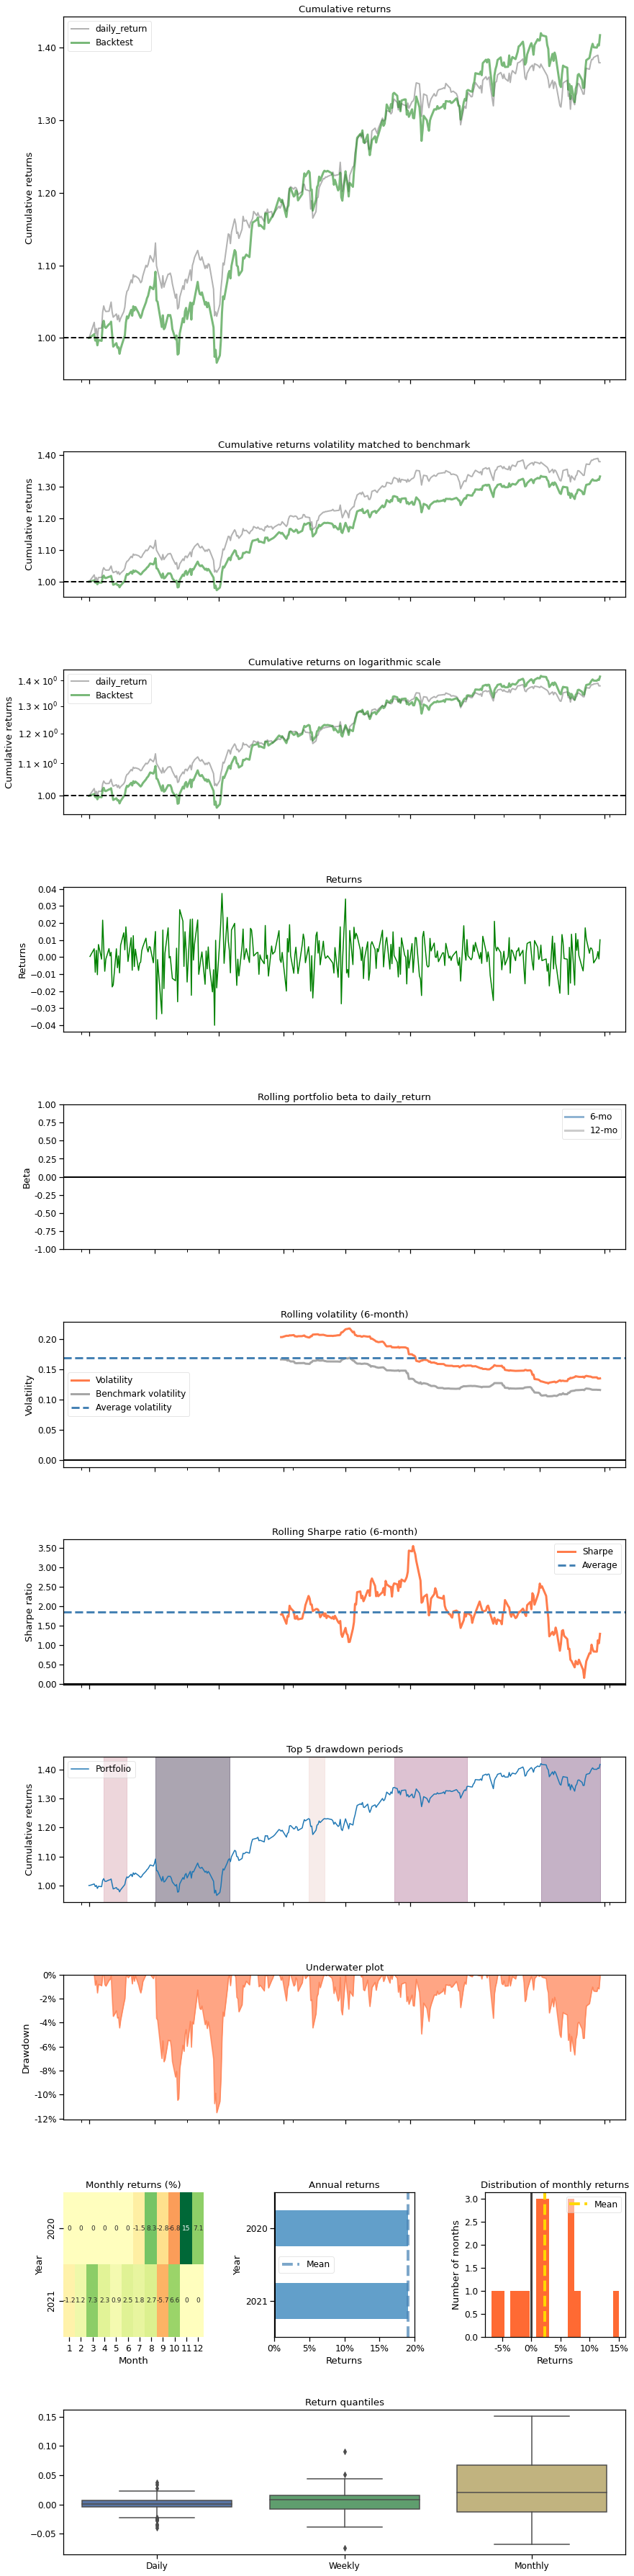

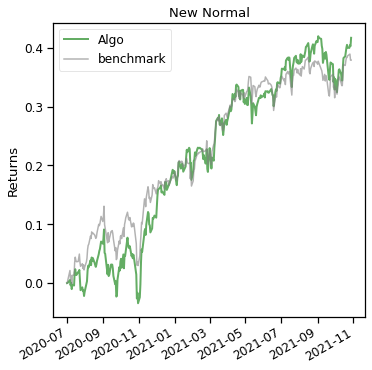

In [ ]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])